<a href="https://colab.research.google.com/github/Praveena-Krishnan/Product-recommendation-system/blob/main/finalpython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from difflib import get_close_matches
from mlxtend.frequent_patterns import apriori, association_rules
import joblib
from tabulate import tabulate
import matplotlib.pyplot as plt

count_vectorizer_file = '/content/drive/MyDrive/count_vecctorizer'
knn_model_file = '/content/drive/MyDrive/KNN model'

# Load the dataset into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/BigBasket Products final df - BigBasket Products.csv')

# Clean the data and create the count matrix
if os.path.isfile(count_vectorizer_file) and os.path.getsize(count_vectorizer_file) > 0:
    count_vectorizer = joblib.load(count_vectorizer_file)
else:
    count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)

count_matrix = count_vectorizer.fit_transform(df['product'].dropna())
joblib.dump(count_vectorizer, count_vectorizer_file)

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

# Initialize and fit the KNN model
if os.path.isfile(knn_model_file) and os.path.getsize(knn_model_file) > 0:
    knn_model = joblib.load(knn_model_file)
else:
    knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
    knn_model.fit(count_matrix)
    joblib.dump(knn_model, knn_model_file)

# Create an empty DataFrame for customer purchases
customer_purchases_file = '/content/drive/MyDrive/FINAL CUSTOMER PURCHASES.csv'

def load_customer_purchases():
    if os.path.exists(customer_purchases_file):
        customer_purchases = pd.read_csv(customer_purchases_file)
        customer_counts = customer_purchases['Customer Name'].value_counts().to_dict()
        return customer_purchases, customer_counts
    else:
        return pd.DataFrame(columns=['Customer Name', 'Product', 'Total Cost']), {}

def save_customer_purchases(customer_purchases, customer_purchases_file):
    customer_purchases.to_csv(customer_purchases_file, index=False)

def content_recommendation_knn(customer_name, title):
    cleaned_title = title.strip().lower()  # Remove leading/trailing spaces and convert to lowercase

    # Find the nearest neighbors
    query_vector = count_vectorizer.transform([cleaned_title])
    query_index = query_vector.toarray().reshape(-1)
    _, indices = knn_model.kneighbors([query_index], n_neighbors=11)

    # Get the recommendations
    similar_df = df.iloc[indices.flatten()].copy()
    similar_df['similarity'] = 1 - cosine_sim.flatten()[indices.flatten()]
    similar_df = similar_df.sort_values(by=['similarity', 'sale_price', 'description', 'rating', 'brand'], ascending=[False, True, True, False, True])
    similar_df.index += 1

    return similar_df[['product', 'brand', 'sale_price', 'description', 'rating', 'similarity']].reset_index(drop=True)

def plot_similarity_graph(recommendations):
    product_names = recommendations['product']
    similarity_scores = recommendations['similarity']

    plt.figure(figsize=(8, 6))
    plt.scatter(product_names, similarity_scores)
    plt.xlabel('Product')
    plt.ylabel('Similarity Score')
    plt.title('Similarity Scores for Recommended Products')
    plt.xticks(rotation=90)  # Rotate x-axis labels if needed
    plt.tight_layout()
    plt.show()

customer_purchases, customer_counts = load_customer_purchases()

while True:
    print('--------------------------WELCOME TO INTELLICART-your personalized grocery store----------------------------------\n')
    customer_name = input("Enter the customer name (or 'checkout' to exit): ")

    if customer_name.lower() == 'checkout':
        print("Thank you for using INTELLICART ..... Exiting...")
        break

    discount_amount = 0  # Initialize discount amount to zero

    if customer_name in customer_counts and customer_counts[customer_name] > 2:
        discount_rate = 0.1  # Discount rate of 10%
        discount_amount = 0  # Initialize discount amount to zero
        print(f"\nWelcome back, {customer_name}! You are eligible for a {discount_rate * 100}% discount on your purchase.")

    while True:
        user_title = input("\nEnter the product title (or 'checkout' to go to home): ")

        if user_title.lower() == 'checkout':
            print("Products added to cart")
            break

        recommendations = content_recommendation_knn(customer_name, user_title)
        if recommendations.empty:

                print("Product title not found.")
        else:
            print(tabulate(recommendations, headers='keys', tablefmt='fancy_grid'))

            # Prompt the user to select a product
            selection = input("Select a product number (1-10) to view details or press Enter to continue: ")
            if selection.isdigit() and int(selection) in range(1, 11):
                selected_product = recommendations.iloc[int(selection) - 1]
                print("\nSelected Product Details:")
                print("Product:", selected_product['product'])
                print("Brand:", selected_product['brand'])
                print("Sale Price:", selected_product['sale_price'])
                print("Description:", selected_product['description'])
                print("Rating:", selected_product['rating'])
                print("\n")

                total_cost = selected_product['sale_price']
                discount_rate = 0.1  # Discount rate of 10%

                if customer_name in customer_counts and customer_counts[customer_name] > 5:
                    discount_amount = discount_rate * total_cost
                    total_cost -= discount_amount
                    print(f"A discount of {discount_amount} applied.")

                customer_purchases = customer_purchases.append(
                    {'Customer Name': customer_name, 'Product': selected_product['product'], 'Total Cost': total_cost, 'Discount': discount_amount},
                    ignore_index=True
                )

                save_customer_purchases(customer_purchases, customer_purchases_file)

                # Plot similarity graph



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------------------------WELCOME TO INTELLICART-your personalized grocery store----------------------------------

Enter the customer name (or 'checkout' to exit): Riya

Welcome back, Riya! You are eligible for a 10.0% discount on your purchase.

Enter the product title (or 'checkout' to go to home): shampoo
╒════╤══════════════════════════════════════════════════════════════════╤═════════════════╤══════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

<ipython-input-2-c37512cc99f5>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  customer_purchases = customer_purchases.append(



Selected Product Details:
Product: Glass Water/Juice Tumbler Set - Ceasar
Brand: Fng
Sale Price: 365.0
Description: Add a touch of elegance to your home bar counter with this set. These are ideal to serve drinks to your guests in style and class! Made of a transparent glass material, this complete set comprises of 4 glasses. Easy to clean after use, this long-lasting glass set can be used to serve a variety of beverages to your guests. These glasses are stackable.
Rating: 4.3


A discount of 36.5 applied.

Enter the product title (or 'checkout' to go to home): home
╒════╤══════════════════════════════════════════╤═════════════════════════╤══════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


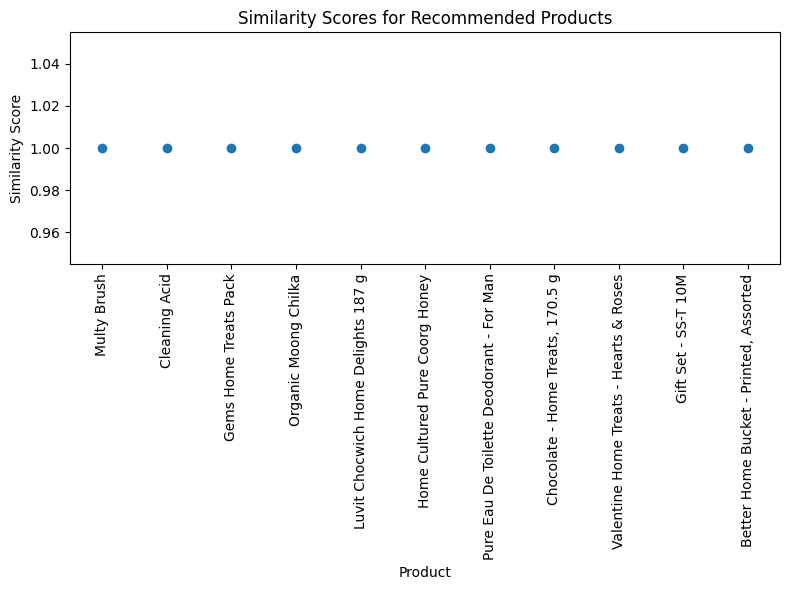

In [3]:
plot_similarity_graph(recommendations)


In [ ]:
print(cosine_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
print(count_matrix)

  (0, 607)	1
  (0, 2210)	1
  (0, 4137)	1
  (0, 6093)	1
  (0, 6711)	1
  (0, 9756)	1
  (1, 1948)	1
  (1, 6766)	1
  (1, 9920)	1
  (2, 1110)	1
  (2, 1987)	1
  (2, 3099)	1
  (2, 7218)	1
  (3, 1264)	1
  (3, 2310)	1
  (3, 2712)	1
  (3, 2783)	1
  (3, 3909)	1
  (3, 4978)	1
  (3, 5576)	1
  (3, 8898)	1
  (4, 1896)	1
  (4, 2906)	1
  (4, 4500)	1
  (4, 8612)	1
  :	:
  (27547, 1162)	1
  (27547, 2561)	1
  (27547, 8354)	1
  (27547, 9814)	1
  (27548, 3275)	1
  (27548, 4137)	1
  (27548, 6929)	1
  (27549, 2600)	1
  (27549, 4573)	1
  (27549, 7109)	1
  (27549, 8772)	1
  (27549, 10050)	1
  (27550, 7960)	1
  (27551, 2467)	1
  (27551, 7112)	2
  (27551, 7344)	1
  (27551, 9085)	1
  (27552, 4379)	1
  (27552, 6790)	1
  (27552, 7539)	1
  (27552, 9189)	1
  (27553, 3142)	1
  (27553, 3366)	1
  (27553, 3733)	1
  (27553, 9618)	1
